# Loading and Reading LIDC-IDRI

---

## Installation and Configuration

In [1]:
import numpy as np
print(np.__version__)
import scipy
print(scipy.__version__)

1.19.5
1.8.1


In [3]:
import pylidc as pl

path = 'LIDC-IDRI'
f = open('C:/Users/anoca/pylidc.conf', 'w')
f.write(f'[dicom]\npath = {path}\n\n')
f.close()

ImportError: Matplotlib requires numpy>=1.21; you have 1.19.5

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.set_cmap('gray')

<Figure size 640x480 with 0 Axes>

---

## Accessing Scans

In this subset, only patients 1 through 30 are accessible.

In [4]:
pid = 'LIDC-IDRI-0001'
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()

Loading dicom files ... This may take a moment.
(512, 512, 133)


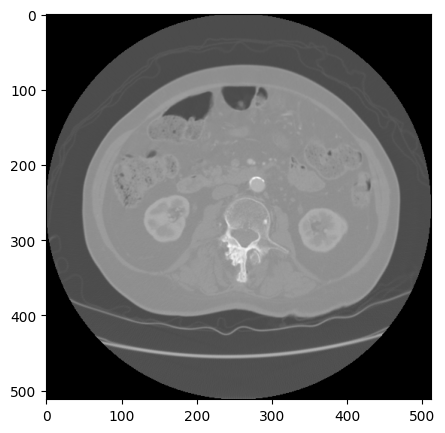

In [5]:
vol = scan.to_volume()
print(vol.shape) # (dim, dim, depth)

plt.figure(figsize=(5, 5))
plt.imshow(vol[:,:,0])
plt.show() # show the first-level slice

Loading dicom files ... This may take a moment.


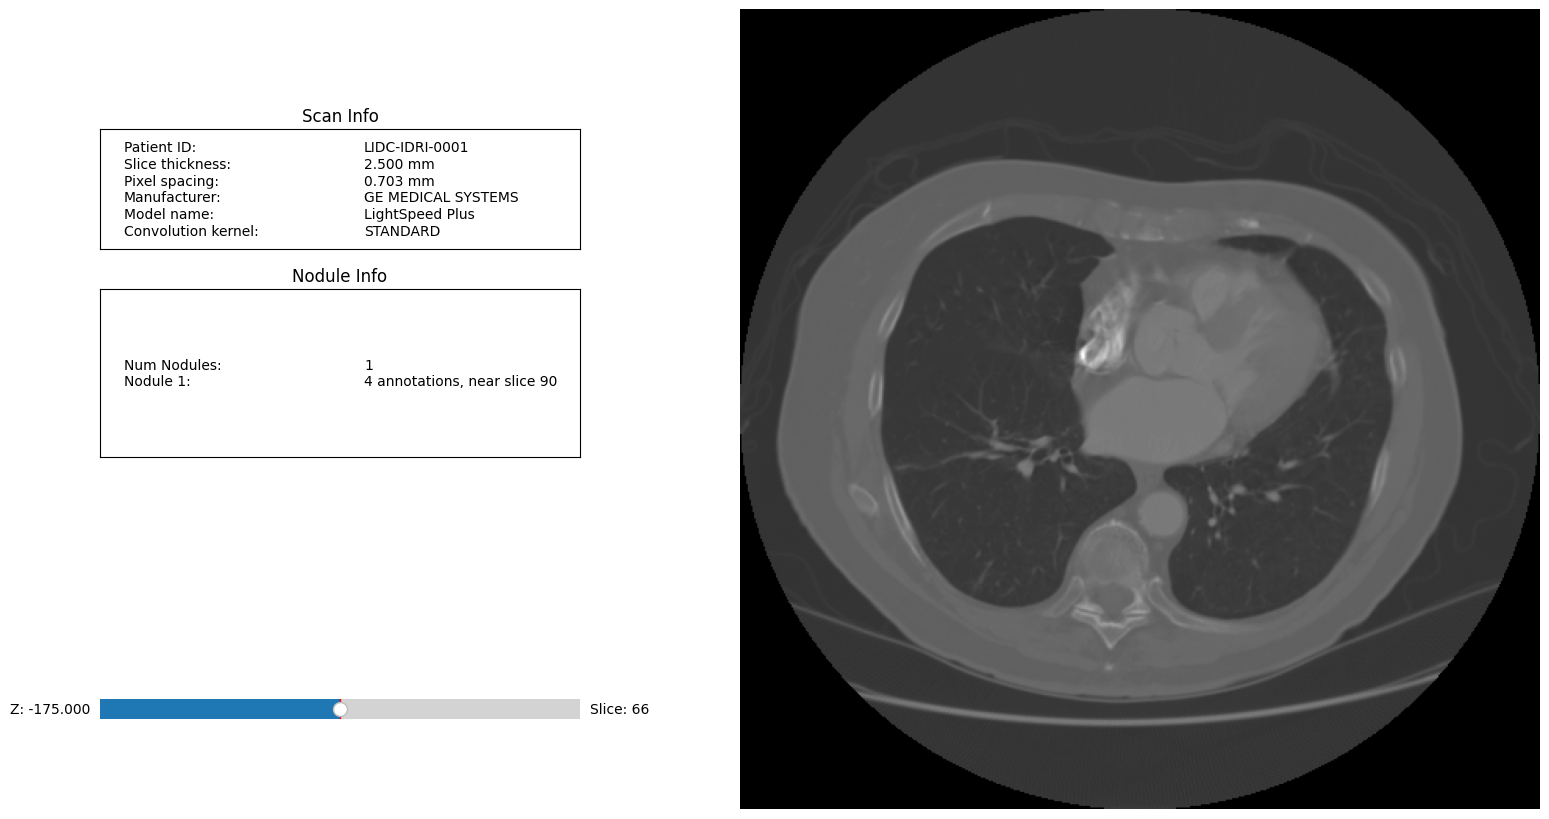

In [6]:
# uncomment for an interactive visualization across depth cross-sections

scan.visualize(annotation_groups=scan.cluster_annotations())

## Accessing Annotations

In [7]:
pid = 'LIDC-IDRI-0001'
annot = pl.query(pl.Annotation).filter(pl.Scan.patient_id == pid).first()

C:\Users\tomas\AppData\Local\Temp\ipykernel_5500\4051012190.py:2: SAWarning: SELECT statement has a cartesian product between FROM element(s) "scans" and FROM element "annotations".  Apply join condition(s) between each element to resolve.
  annot = pl.query(pl.Annotation).filter(pl.Scan.patient_id == pid).first()


In [8]:
annot.print_formatted_feature_table()

Feature              Meaning                    # 
-                    -                          - 
Subtlety           | Obvious                  | 5 
Internalstructure  | Soft Tissue              | 1 
Calcification      | Absent                   | 6 
Sphericity         | Ovoid                    | 3 
Margin             | Near Sharp               | 4 
Lobulation         | No Lobulation            | 1 
Spiculation        | No Spiculation           | 1 
Texture            | Solid                    | 5 
Malignancy         | Indeterminate            | 3 


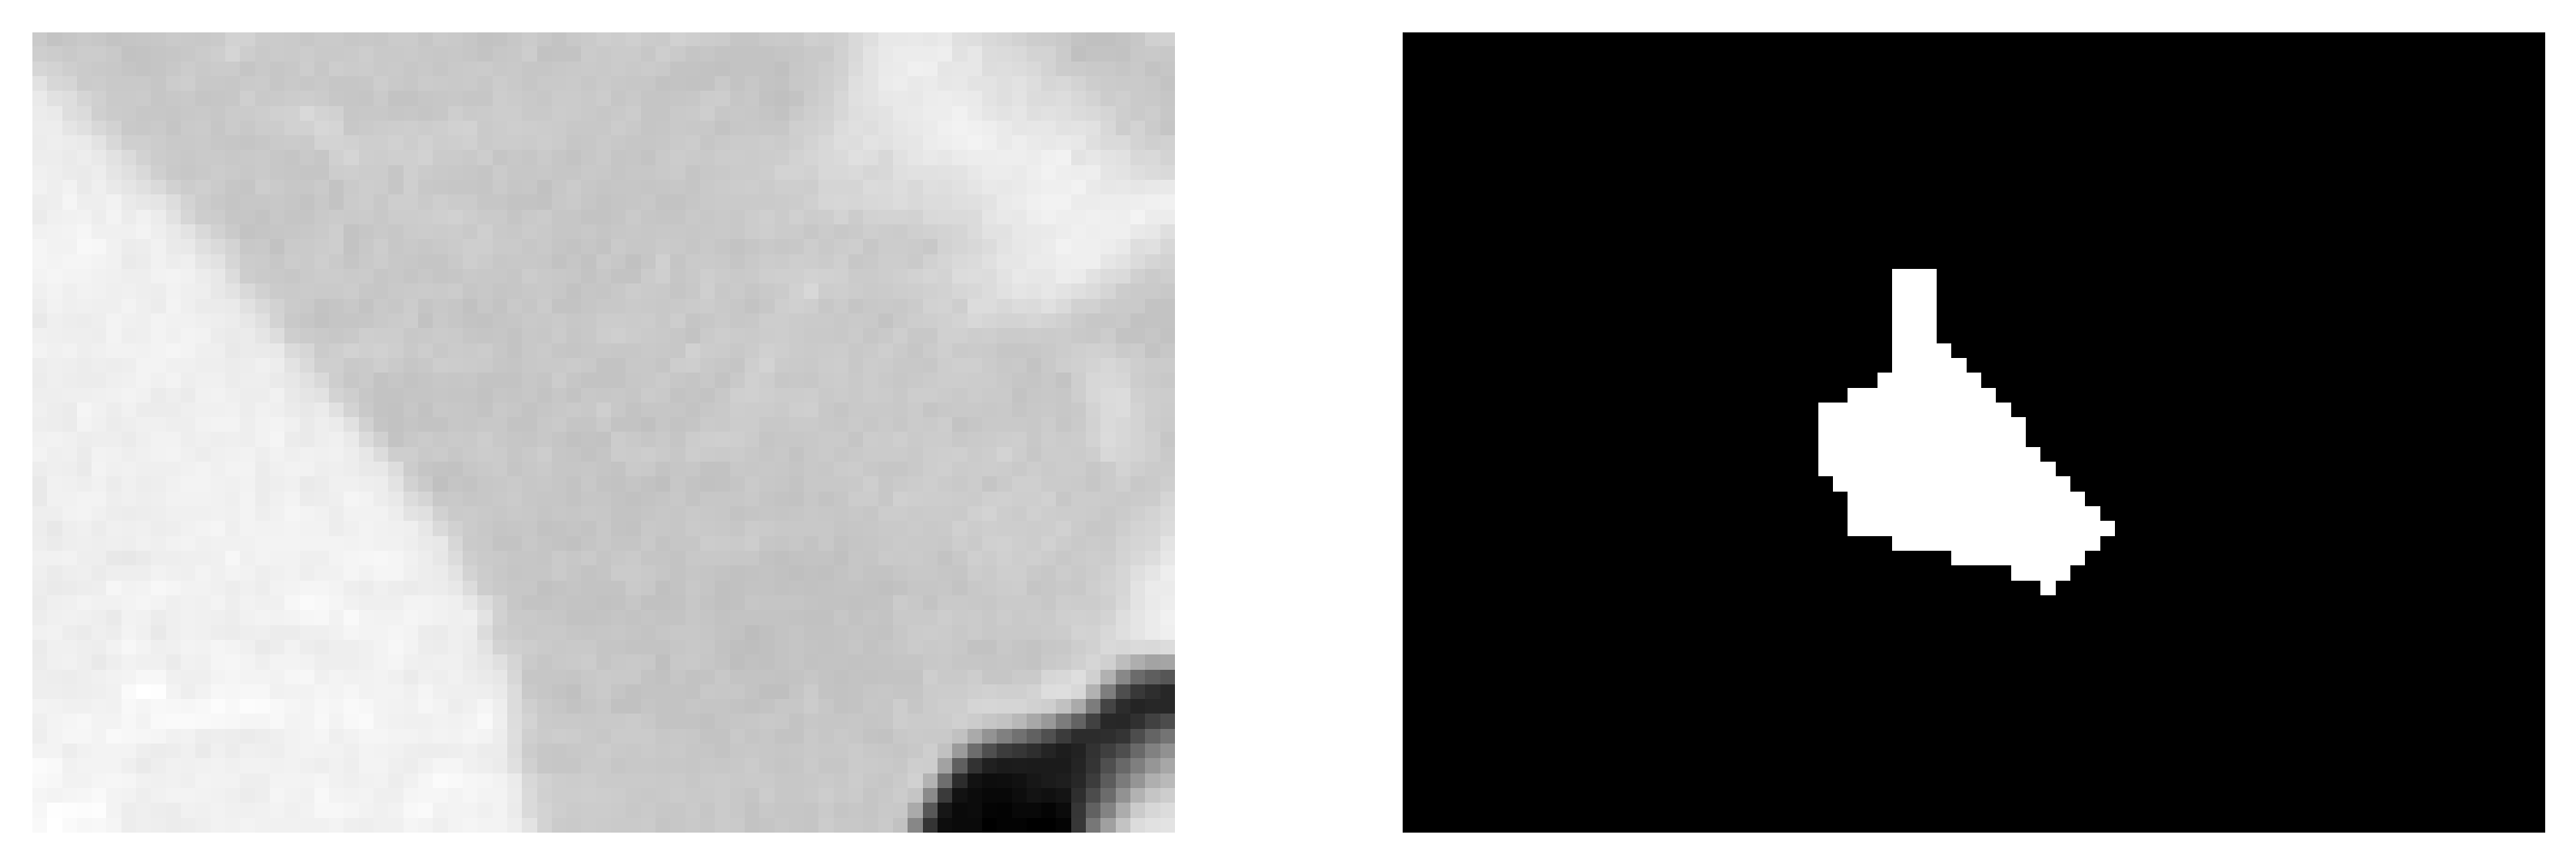

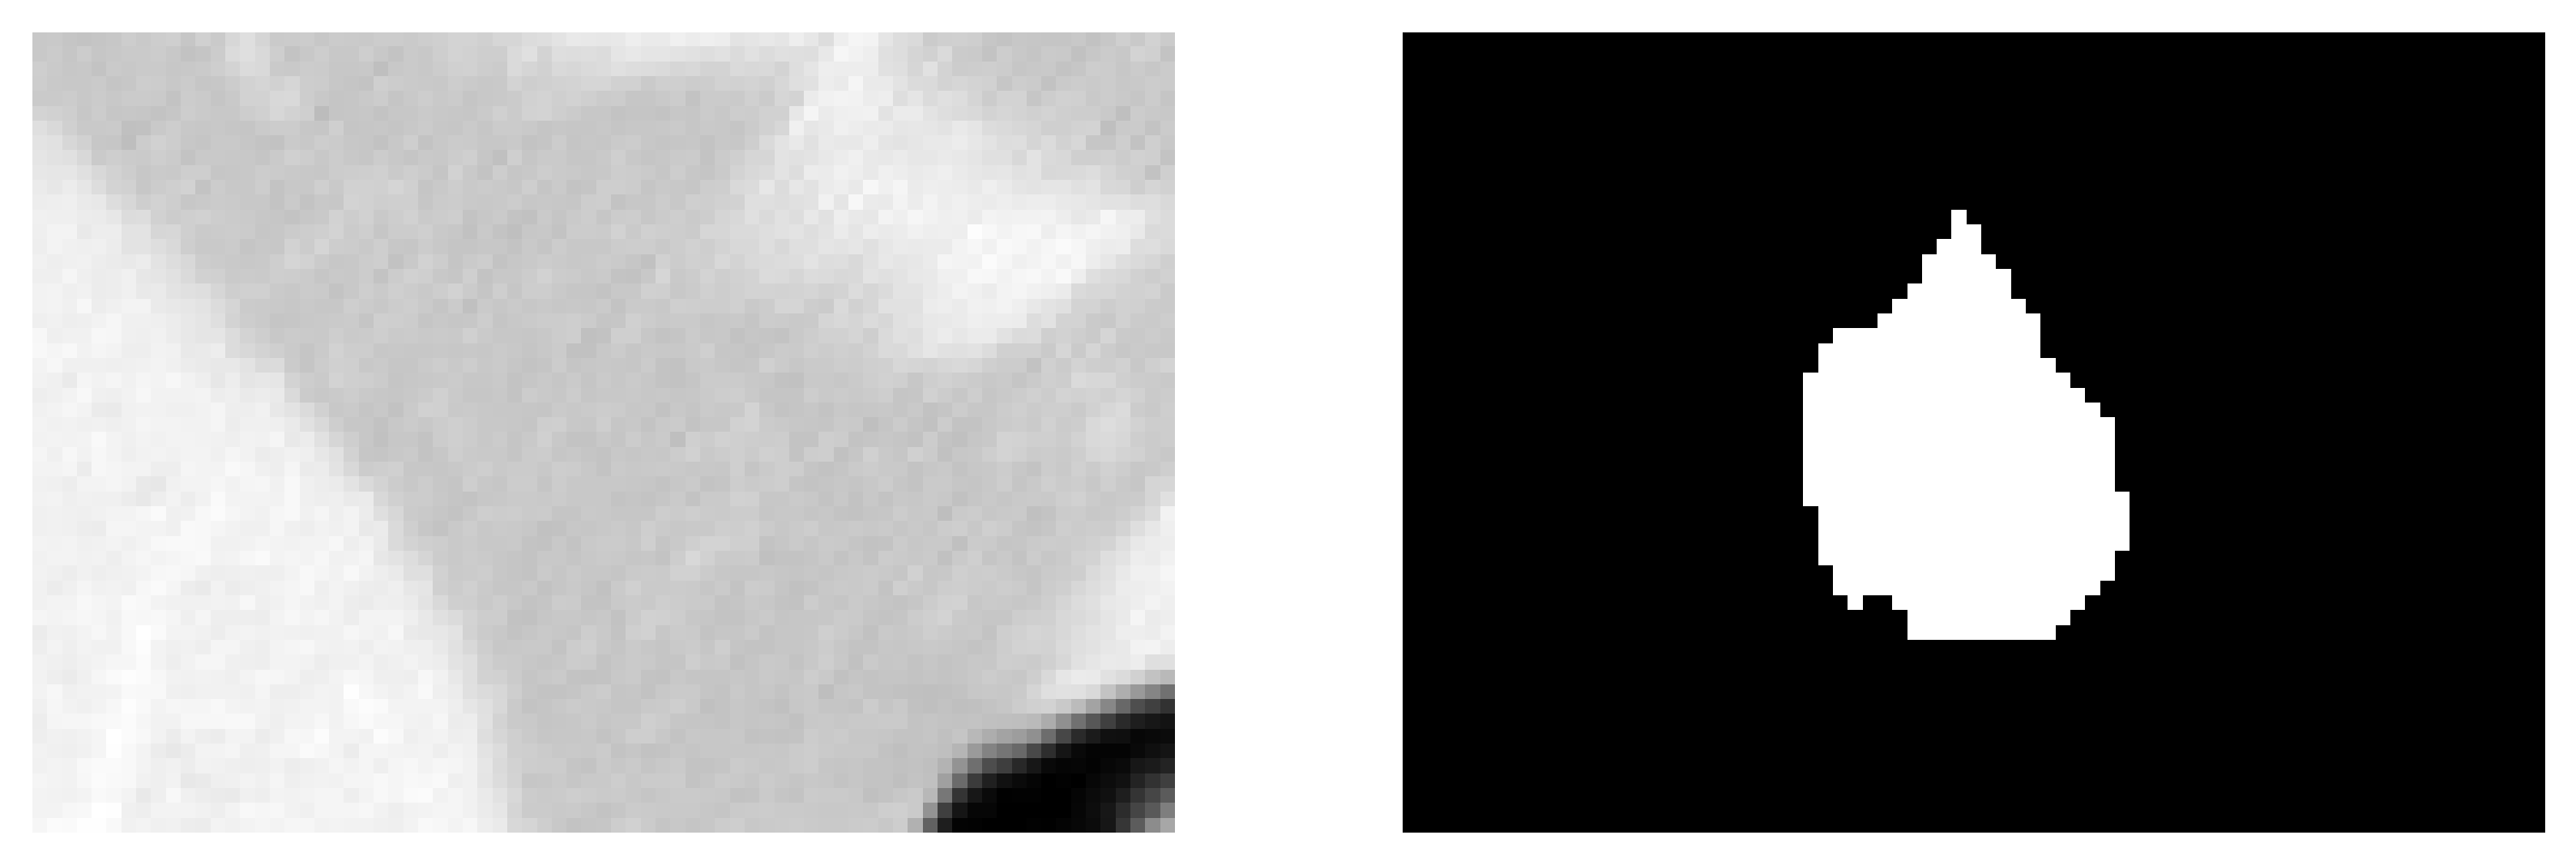

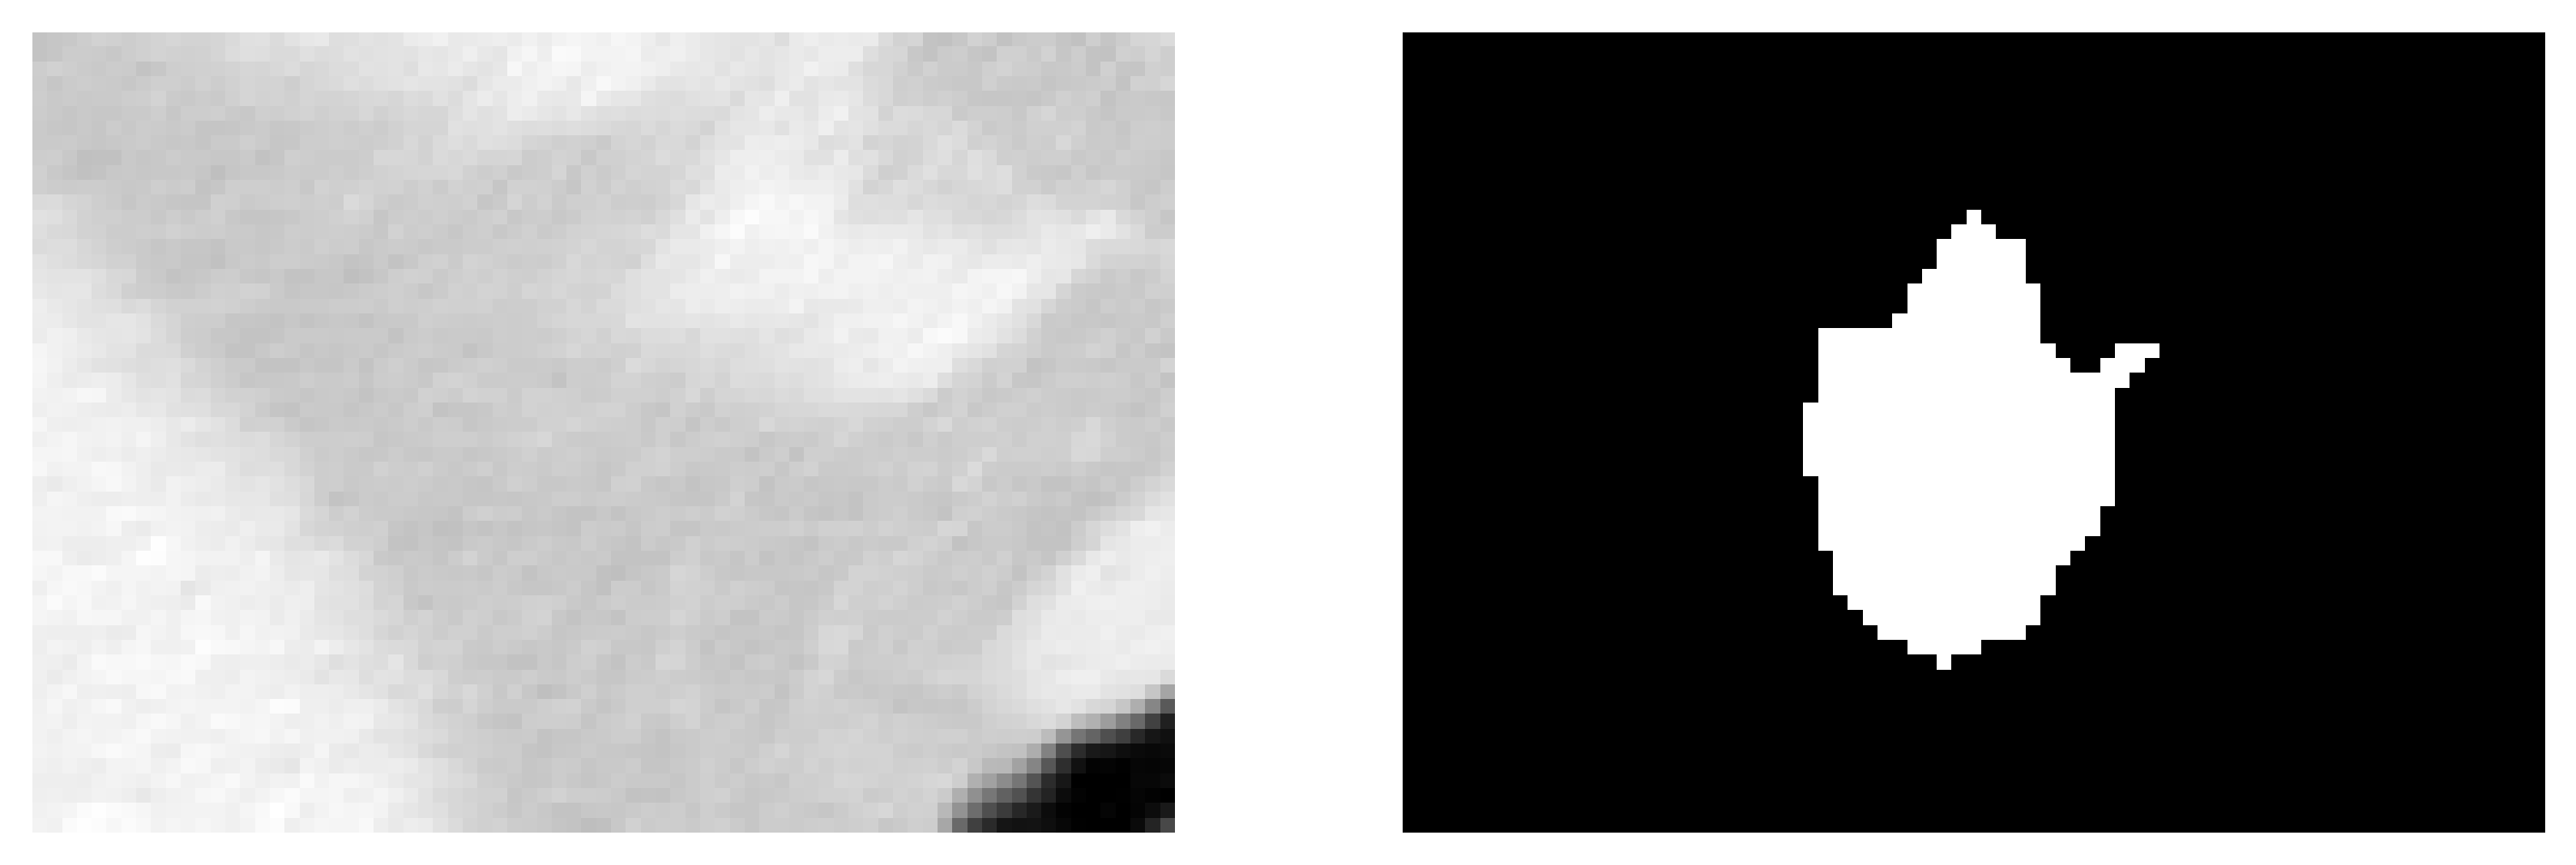

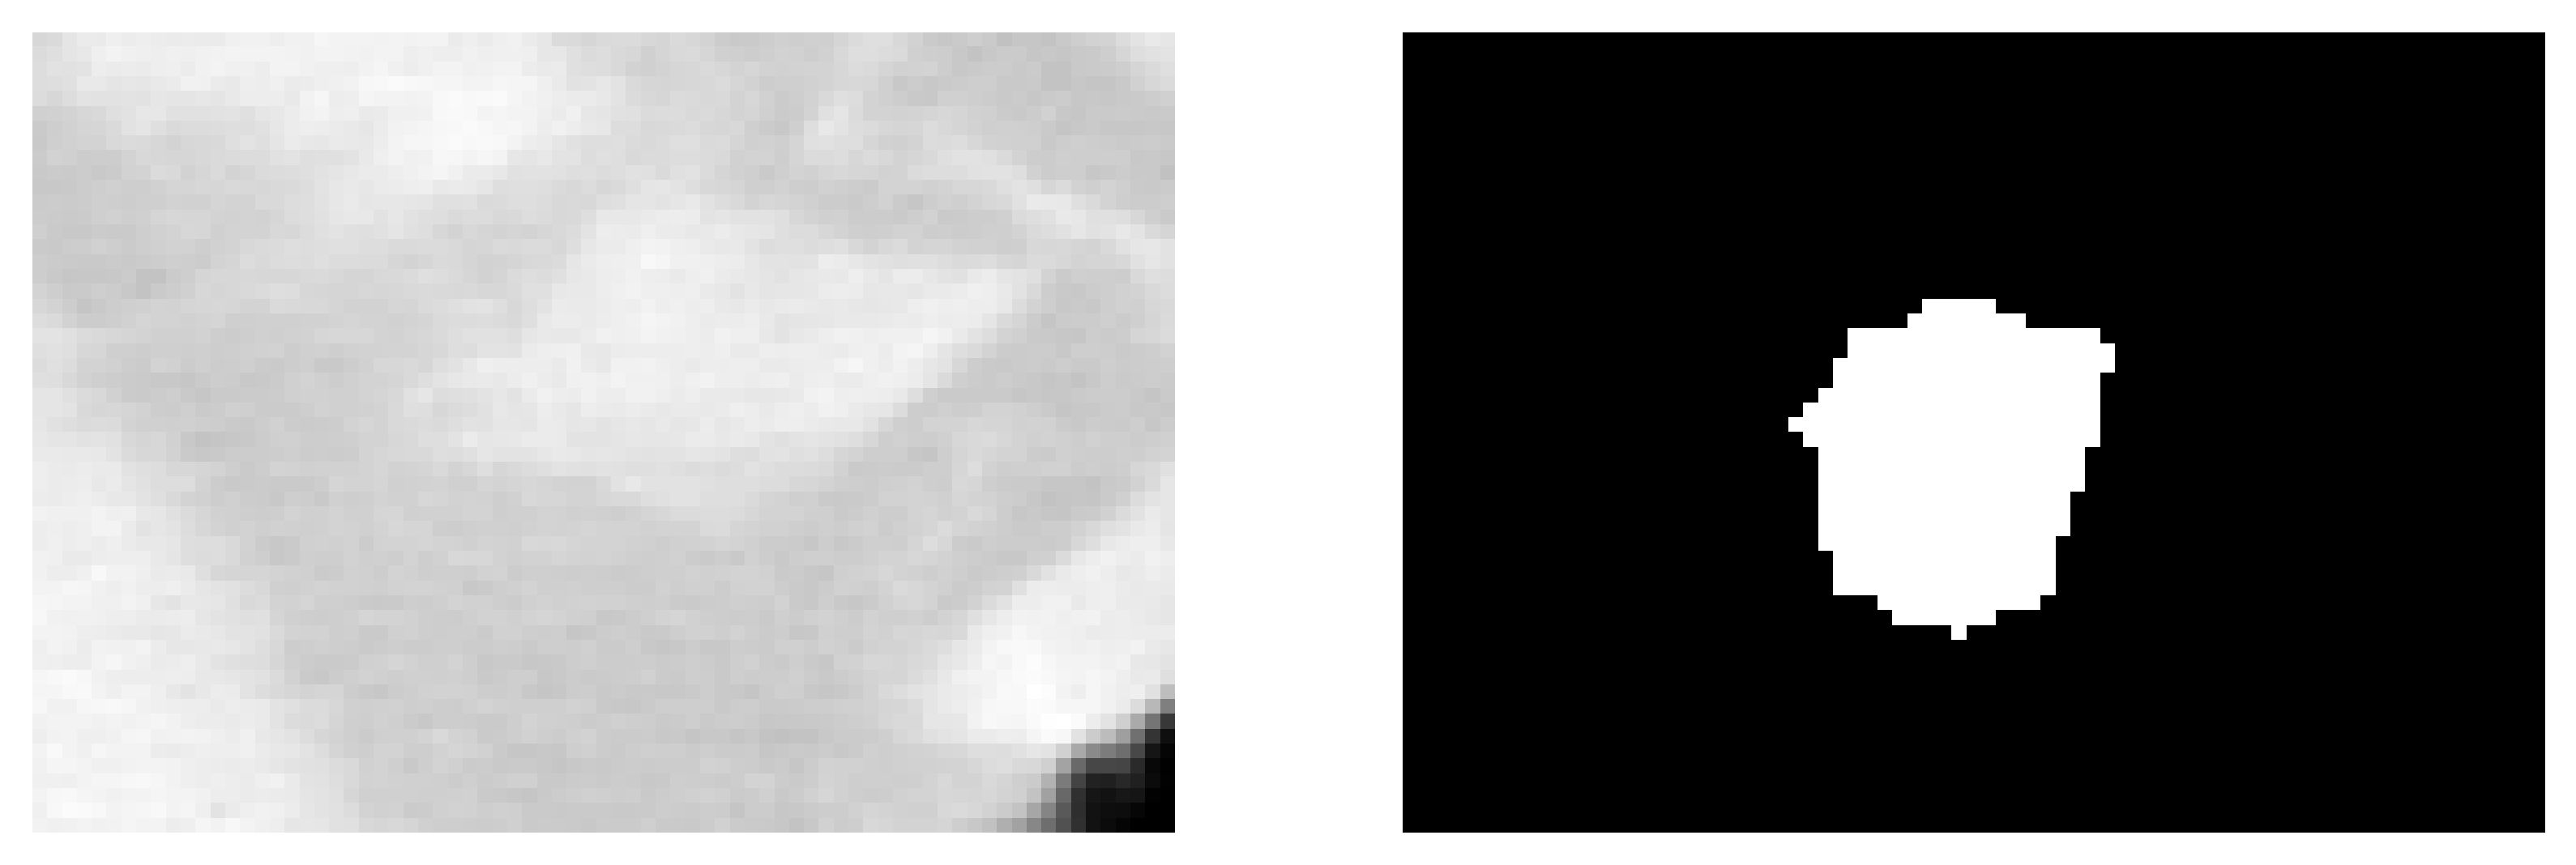

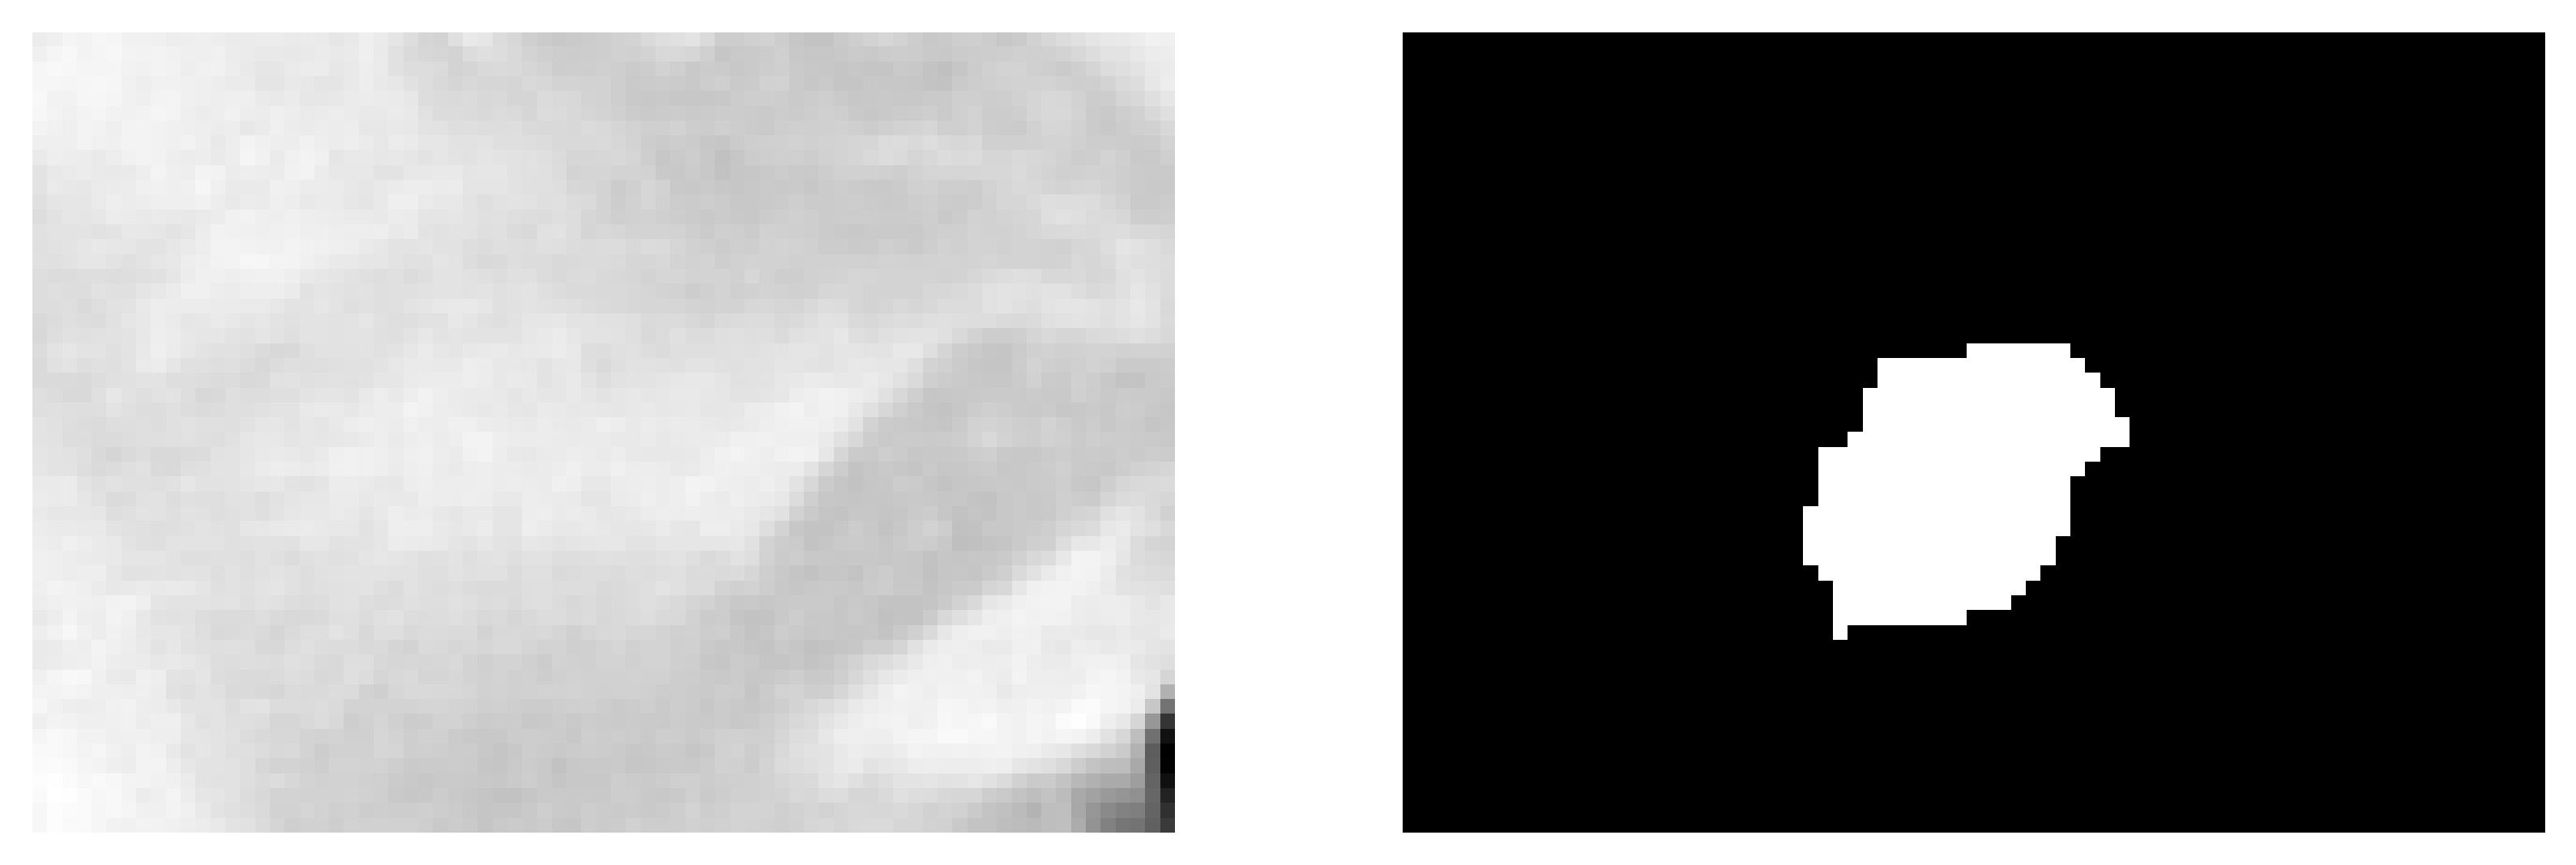

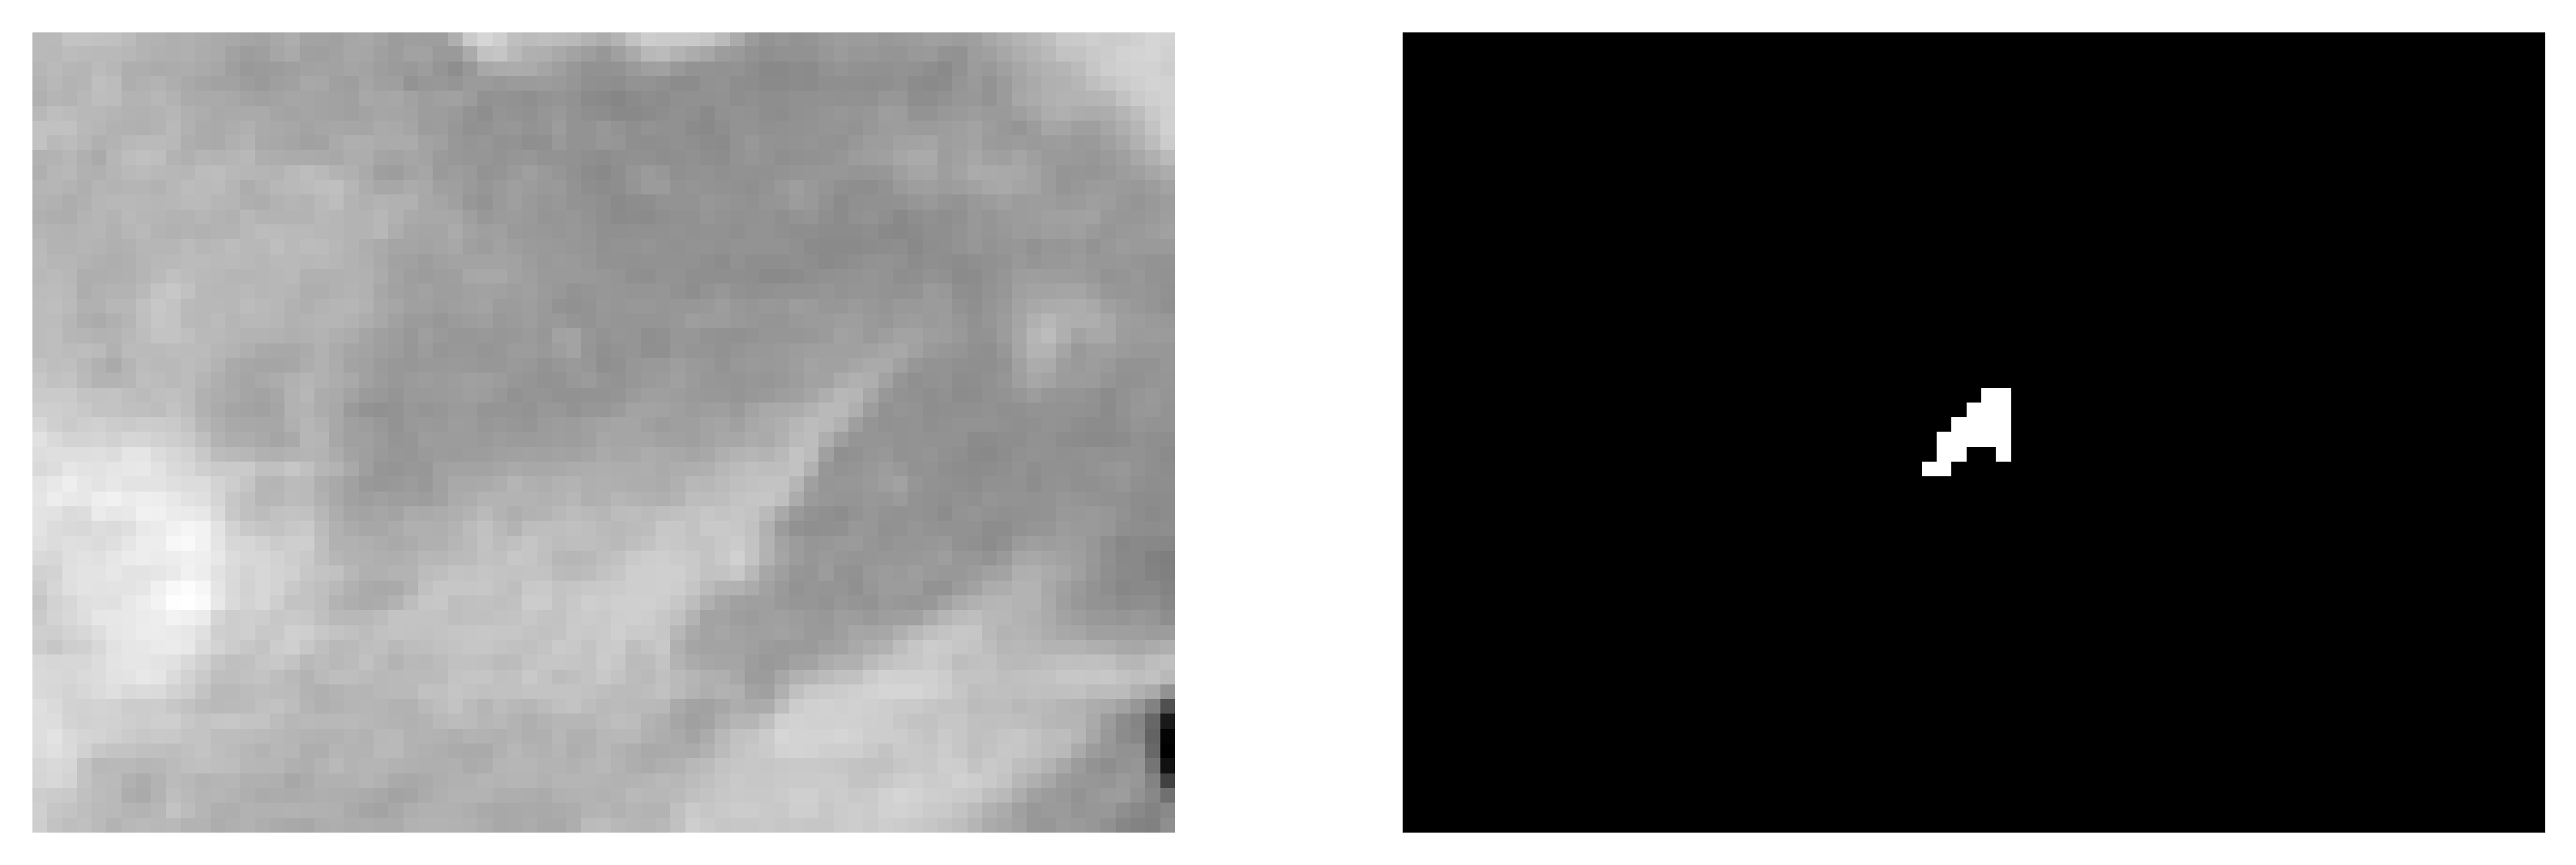

In [9]:
padding = [(10, 10), (25, 25), (0, 0)]

masks = annot.boolean_mask(pad = padding)
bbox = annot.bbox(pad = padding)
relevant_vol = vol[bbox]

for region in range(masks.shape[2]):
    
    plt.figure(figsize=(10, 5), dpi=400)
    plt.subplot(1, 2, 1)
    plt.imshow(relevant_vol[:,:,region])
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(masks[:,:,region])
    plt.axis('off')
    plt.show()
    plt.close()

---

## Accessing Annotations by Annotator

In [10]:
from pylidc.utils import consensus
from skimage.measure import find_contours

Loading dicom files ... This may take a moment.


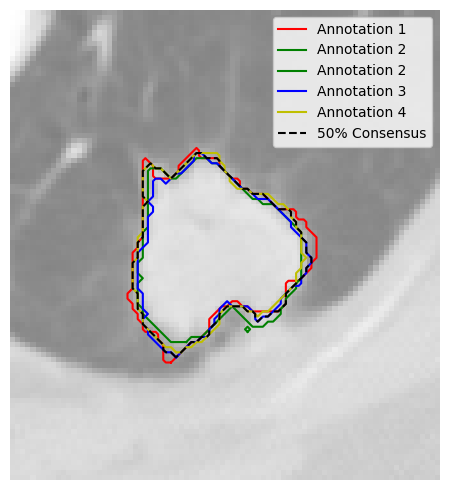

In [11]:
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == 'LIDC-IDRI-0001').first()
vol = scan.to_volume()

nods = scan.cluster_annotations()
anns = nods[0]

cmask,cbbox,masks = consensus(anns, clevel=0.5,
                              pad=[(20,20), (20,20), (0,0)])
k = int(0.5*(cbbox[2].stop - cbbox[2].start))

# Set up the plot.
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(vol[cbbox][:,:,k], cmap=plt.cm.gray, alpha=0.5)

# Plot the annotation contours for the kth slice.
colors = ['r', 'g', 'b', 'y']
for j in range(len(masks)):
    for c in find_contours(masks[j][:,:,k].astype(float), 0.5):
        label = "Annotation %d" % (j+1)
        plt.plot(c[:,1], c[:,0], colors[j], label=label)

# Plot the 50% consensus contour for the kth slice.
for c in find_contours(cmask[:,:,k].astype(float), 0.5):
    plt.plot(c[:,1], c[:,0], '--k', label='50% Consensus')

ax.axis('off')
ax.legend()
plt.tight_layout()
plt.show()